#### [ <a href='http://ifni.co'>HOME</a>  ]=====  How to compute like a brain =====[ <a href='http://ifni.co/toc/programming'>Programming</a>  ]

In [14]:
%matplotlib inline

import sys
sys.path.append('../lib')
import numpy as np
from scalar_encoder import *
from category_encoder import *
from bmap2D import *
from temporal_memory import *
from pattern_lang import *
from utils import *

# Bare-Bone HTM

##### (babyHTM, bbHTM)

*Currently the main trend to solve the AI challenge is mostly based on mathematically inspired approach i.e. the perceptron-layered "neuro" networks.
This approach achieved big success so far in solving very complex problems, even spectacularly beating human  in some narrow tasks.
Still if the 60's logic AI was brittle the new 2016 statistical AI is fragile.
One alternative approach taken by Jeff Hawkins and his team at Numenta is human brain inspired approach.
They have build a theory and framework to do that, called Hierarchical Temporal Memory (HTM).
The following article uses a simplified and abstracted approach, stealing as much as possible from Numenta ideas at the same time trying some tweaks of my own.*

*I hope you enjoy **bbHTM**.*

-----------------

Before we start with the meat of the matter let's explore somewhat the basic differences between the traditional approach and HTM.
Traditional NN use as a basic building block artificial-neuron called **Perceptron**, which has almost nothing to do with the real neuron, but is just superficially similar. It will be more correct to call it *linear classifier* instead.
In addition the output signal of this classifier is modified by a non-linear function, so that it can change within specific boundaries or to limit the behavior in some way.
Here is schematic of the percepton :

![perceptron](imgs/perceptron.png)

The perceptron works by multiplying the input signal by the weights.

$$ out = \sum\limits_{i=1}^n  w_i * x_i $$

The way to learn to classify data is to adjust the weights in such a way so as to predict correctly provided pairs of input and output data.
Next those pseudo neurons are paired in a layer, when multiple layers are connected together you build a network.

![nn](imgs/nn.png)

Now, the normal procedure is to train the NN with labeled data in a similar fashion that we do single Perceptron (this is the general approach, there is also unsupervised variants).
You pass data on the input and then propagate the signal through, doing the necessary calculation in-between.
Once the result is out (prediction) we compare it with correct output (i.e. the labeled data).

There will be almost certainly a differences between predicted and labeled output, so we take this difference and propagate it backwards adjusting the weights and biases by a small amount so that next time when we do forward pass the prediction differ less and less.
After that we pick another data-item or batch-of-data ... rinse and repeat, until we get pretty close to the original labeled data.

After doing this we have well-tuned network that can classify correctly data similar to the one we trained.

The method of going backward trough the network is called **Backward propagation** and the slight adjustment made on the way is called **Stochastic Gradient Descent** (*there are variation on those too*).
This simplified model suffer from a "small" problem which did not allow NN to be used widely up until ~10 years ago. (NN were first introduced in the dawn of AI).

The problem is called *"the vanishing gradient problem"* and happens when we chain many layers together. Because different layers learn with different speeds it happen that layers close to the output learn alot faster, but layers at the beginning are stuck and learn almost nothing (the adjustments are smaller and smaller the deeper the network), so that NN can not be used to solve problems above specific "complexity", no matter how many new layers we add.
So adding more layers only increases the computation time without improving the prediction capability.

There is need for more layers so that we can represent richer models and find deeper patterns in the data.
The so called "deep networks" solved this problem by adding bottleneck (more or less) at some point inside the NN thus forcing the multi-layered network to act as multiple multi-layered networks.
Further the NN proliferated even more by replacing the building block i.e. the Perceptron with more complex mathematical abstractions.

Because most of NN are implemented using matrices, if you are more mathematically inclined you can think of NN as giant swarm of fine tuned linear equations.

Basic characteristics of this NN approach are :

	1. Batch learning
	2. Backpropagation
	3. SGD like fine tuning
	4. Real valued data
	5. Dense representation
	6. Static - no concept of time
	7. Computation
    8. Learns by connections weights

The brain on the other hand does nothing like that, but :

	1. Online learning
	2. Binary data
	3. Sparse representation
	4. Dynamic - time is integral part
	5. Pattern Memorization
    6. Learns by Existence or non-existence of connections 

The HTM theory and framework from Numenta team is trying to mimic how the neuro-cortex of the brain works. The idea came because research showed that the neuro-cortex seem to be organized in a very uniform way. So if we can understand how the "basic" structure in the cortex work, then we can eventually use it as a template for building software that can do better AI.
The first major difference of the HTM to NN is the building block, HTM implements more believable approximation of the brain-neuron. 

![HTM neuron](imgs/ann.png)


You can find more info <a href="http://arxiv.org/pdf/1511.00083.pdf" target="_blank">here</a>, but in general here are some details :

- HTM-neuron uses **permanence**, instead of **weights**:
Which act more like a switch rather than a continuous function. Above specific threshold the input switch from 0 to 1. I.e. permanences are still real numbers like weights, but they "generate" binary result.

- There are also at least two categories of inputs **proximal** and **distal** (modeled on the neuron dendrites).
Proximal inputs are summed, much like those in the perceptron (*this is the linear component*), but distal are combined in separate groups and act as signal detectors (*this is the non-linear component*).

- *Distal* inputs/dendrites do not cause the HTM-neuron to 'fire', but only predispose it to 'fire'. This is essential for prediction.

Because the HTM-neurons is not an exact copy of the real one and also so that we don't get confused with current terminology, Numenta are calling them **"cells"**.

The other difference is the way the cells are organized. Instead of **network**, we use **region**.
Each region consist of cells organized in **columns**, "spliced" together.
(Here I will use 2D analogy, because that's how I did the implementation, but in Numenta videos they sort of use 3D regions.)
So you can think of *region* as 2D-table, where the building block is the **cell**, but the main organizational unit is the **column**.
This is not coincidence that is how more or less neuro-cortex works (which is the thing HTM tries to model).


![region](imgs/region.jpg)


Next organizational unit is the **layer**, every layer consist of multiple regions. A region can connect with region in another layer.

*There is not much details on this yet, current theory does not cover exactly how the hierarchy of layered regions will work, but they are working on it.*

----

## WHAT IS SDR ?
---

The data representation used in the cortex and in the HTM is not real-valued-dense vectors, but binary **Sparse Distributed Representation** aka **SDR**. This is a major difference to any other approach of doing  computing and the reason is that it is not a representation well suited for Computation, but representation very well suited to Memorization. The brain is memory not calculator.

This presents some problems because we have to figure out how to convert our data to SDR, but also allows us to do things naturally almost impossible with the computational approach.

#### So what is SDR ?

First thing SDR is binary i.e combination of 1|0, yes|no, not real-valued 2.33, 4.68, 222.567.

Second it is sparse and distributed. This guarantees that if a small number of bits change randomly it wont impact the overall meaning of the data.  

To get better idea what SDR mean it is best to see how the opposite work i.e. **Dense** representation.
One very good example very often cited is the ASCII code.

In [1]:
bin(ord('A'))

'0b1000001'

if we change just one bit, f.e. the second one :

In [2]:
chr(int('0b1000011',2))

'C'

the result is different character. The meaning of how the characters are encoded in ASCII is totally arbitrary and changing even a bit changes the meaning i.e. different character. The bits have no meaning.

In SDR changing single bit doesn't change the overall meaning. 
The meaning of a bit is not assigned, but is learned.
Also as the name *sparse* implies the number of ones is just small percentage of the whole bit-string. 
For example in typical SDR with size 2048 bits the number of ON bits is at most 40 bits on i.e. just 2% of the total number of bits.

> 01000100000000000000000000000000000000000000100 ..... 000000000000000000000000000000000000000100010000000


Dense representation have the advantage of being able to utilize all bits, and enormous amount of permutations **2^n** to be precise. 
But the way we solve this problem with SDR is to use much much larger bit-strings, the accepted rule of thumb is at least 1000 bits.

### Why SDR work ?

> === TODO ===
I will fill this part as I have some more time ...


### Properties of SDR

Let's explore some of the major properties of SDR, so you can understand the theory and code better.
The following paper is the best source if you want to dig down : 
<a href="http://arxiv.org/abs/1503.07469" target="_blank">Properties of Sparse Distributed Representations and their Application to Hierarchical Temporal Memory</a>,
but I will do quick overview.

SDR have 3 major properties :

1. Sub-sampling
2. Classification
3. Union

Before we start we need to make some definitions.
SDR is a binary vector.
We determine similarity between two SDR vectors we use **overlap score**, which is simply the number of ON bits which match.

$$ overlap(x,y) = sum(x & y) $$

Compare that to Hamming distance which measure how much both vectors differ (HTM do not use hamming distance in any of its algorithms, so far).

$$ hammingDistance(x,y) = sum(x  \hat{}  y) $$

**Matching :** We decide that two vector match if their overlap is above specific threshold. 

$$ match(x,y) = overlap(x,y) >= thresh $$

To understand SDR properties we will have to also understand what **"Overlap set"** is.
Overlap set is the number of combinations of vectors we can get that have exactly **b** bits of overlap WITH a vector **x** with size **n** and number of **ON** bits **w**.

So the number of those combinations is given by the formula :

$$ |O_x(n,w,b)| = {w_x \choose b} * {n - w_x \choose w - b} $$

> TODO .....

- **Sub sampling** : This property allows us to figure out if specific pattern is contained in an SDR, by comparing just small number of all bits that comprise the pattern.
(A group of distal dendrites do that to discriminate if specific pattern to which a neuron have to react has occurred.)   

- **Classification** : Let say we have a bunch of unique SDR's (where unique means they don't match according to specific threshold). Given that, how reliably we can say if a new SDR is part of this list or not i.e. classify.

- **Union** : Is a property of SDR that allows us to store reliably a list of patterns (by OR-ing them together) and consequently ask if new SDR is a part of that list.
(Allows us to do classification without the need to store all the patterns)

You should look at the paper to see numerical examples of reliability of those properties for different values of n,w,b and threshold. Suffice to say as long as the vectors are Large > 1000, Sparse < 5% and Distributed the properties hold pretty well.

My current implementation uses exclusively the UNION property of SDR.

## How HTM region work !
---

<a href='http://numenta.com/assets/pdf/whitepapers/hierarchical-temporal-memory-cortical-learning-algorithm-0.2.1-en.pdf' target='_blank'>HTM theory</a>

The main function which neuro-cortex as we understand it now is to memorize and replay sequence of sequences (time-patterns) stored in hierarchical layered structures.

Said in another way : find patterns coming from the senses, build models of reality and do predictions.
Prediction is intelligence.

The HTM theory provides the framework to do all this and here are the steps how you do that for a single HTM-region.

0. **Semantic extraction (human) :** Pick the semantic information from the data.
1. **Encoder :** Dense to Sparse. Convert semantic info to positions in a sparse bit-string.
2. **Spatial pooler :** from Sparse to Sparse Distributed. Find Spatio-temporal patterns.
3. **Temporal/Sequence Memory :** Discover, store and reply temporal patterns. (nth-step ahead)
4. **Temporal pooler :** Stabilize the output temporal patterns, aggregate.

I started this project with the idea to implement Spatial Pooler and Temporal Memory on my own as exercise to understand the technology.
If my code or implementation does not seem to follow very close the Numenta NuPic application or theory there is good reasons for this.
First I wanted to do it in more abstract and simplified way, second I've not used NuPic application at all and have not read the code, so I had to come up with my own solutions to solve the problems I created for myself not following the exact recipe ;).

My other excuse is that HTM is in flux :), so it is a moving target anyway.

The source of guidance for me were the published papers and videos, some of which I linked in this article.
What I currently describe is the 2-3rd rewrite of the code. My first version of both SP and TM was very close to one described in the paper using mostly numpy, but as you will see in a while I had to scrap the TM for good reason, as for the SP I want to base it on the ideas I got from my current TM implementation.

Let's now go in more details .....

## Semantic extraction
---

This is the part for which I have the least clear idea yet how to automate. May be once we have full working HTM we can use it to do this task for us ;)

So what it is all about ? Normally we get data which can be in many different formats : *real numbers, integers, categories ; numbers, date, time, color, weight, height ...*
In the NN world you can sometimes use the data as it is or slightly reshape it and you are ready to go.
But in HTM as we saw we need to convert the data to **SDR**.
The tricky part is we can not do this mechanically. We have to extract the semantic information or explore hidden 'relations' and then encode them with bits at specific positions in the SDR. Remember every bit has a meaning, bunch of bits builds a spatial or temporal relation, a concept.
This has to be done by human, so far I don't know of a general way to extract the semantic information out of any type of source data. 

Once we figure the semantics of the data we build Encoders to do convertion to SDR format.

## Encoding 
---

<a href='http://arxiv.org/abs/1602.05925' target='_blank'>Encoding Data for HTM Systems</a>

Encoders are normally built once per data type and then reused. The basic goal as we mentioned already is to capture the best we can the semantics of the data.

Let's think of some examples .... let say we want to find patterns about flowers, one semantic characteristic would be color.
We can represent it in two ways : as a category (red,green,blue,violet) or as RGB color. 
If we do category we may decide to stick with 10 discrete colors.
These are our categories and their bits don't overlap (unless we want to also represent red-greenish, blue-reddish ....etc ).
So if we have n=100 bits as our input vector we can dedicate 10 bits per color.

Another example is numbers. Let say we measure the flowers sizes and they range from 10 cm to 100 cm.
So our specs will be :

** n=20, start=10 , end=100, width=10 **

Number of bits is n=20, width=10 is how many ON bits we would use at any given time.
It is obvious we can not use a bit for every number, because the number of available bits is smaller than the numbers we want to represent. Also we don't want the meaning to change when we change just single bit, remember ASCII.
So we would use multiple bits to represent range of numbers.
We also slide those bits to represent overlapping ranges.

Lets give it a try, I built the Scalar encoder so we will just use it :

In [4]:
import sys
sys.path.append('../lib')
from scalar_encoder import *

In [2]:
se = ScalarEncoder(minimum=10, maximum=100,nbits=20,width=10)

In [3]:
se.info

> Scalar encoder -----
min-max/range : 10-100/90
buckets,width,n : 11,10,20


as we can see we use 10 bits for a range. And "buckets" here describes how many ranges we have in total.

In [9]:
se.encode(11)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [4]:
se.encode(33)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

do you see the sliding window... now for something surprising.

In [5]:
se.decode(se.encode(33))

26.0

it looks wrong, but is not ... remember we are in fuzzy territory.
In this case it is particularly jumpy because "n" is too small. Try bigger one.

Let's try color categories we mentioned earlier.

In [3]:
from category_encoder import *

In [5]:
ce = CategoryEncoder(nbits=10,ncats=5)
ce.info

> Category encoder -----
Num of categories : 5
Num of bits : 10


In [4]:
ce.encode(3)

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0], dtype=uint8)

You have to have Encoder for every data type, but again you have to build it only once. Also you can splice together different bit arrays to built your compound SDR. There is module in the repo for that.

> I would like to do separete doc on Encoders if I find time. There are several other implemented in the repo, if you are interested.

## Spatial pooler : part 1
---

Here I will just describe the requirements for Spatial pooler. In **SP : part 2** we will look at the implementation.

*The reason I'm spliting this in two is because SP will be implemented with the ideas we develop during TM discussion.*

The goal of Spatial pooler is to make the Sparse result from the Encoder a Sparse-Distributed.
In addition there are several constraints which has to be met.

1. **Similarity** : Preserve similarity f.e. if we encode with ScalarEncoder two numbers and they have 5 bits overlap, we should expect the SP to preserve similar count of overlapping bits.
2. **Uniquiness** : Unsimilar values should have as small overlap as possible.
3. **Distributed** : The SP should use the availible bits as much as possible.

This makes the SDR robust to noise and loss of information (bits).

---

## Temporal/Sequence Memory
---

Temporal memory (TM) is the core component of the HTM framework, the heart of the system.
Our brain constantly receives sensory data and at the same time does prediction of what will happen next.
If the prediction is incorrect it self-adjusts to incorporate the new information.
In a similar manner NN adjust its weight via Stochastic gradient descent and Back-propagation.
The big difference is that the brain does this "online" every single datum for every single time-sequence, all the time, every time on every level of the hierarchy from neuron to column to region to layer ... did I say time is integral part of the learning process.
The implication is that we need some structure and process to implement such system.
That is exactly what **TM region** is for.

First the structure: as I already mentioned we use a **region** (you can visualize this as 2D table), with main organizational unit the **column**, constituted of **cells**.
Every cell can be in one of three possible states **active/on**, **predicted**, **inactive/off**.

The signals flow **vertically** or **laterally** (compared to NN forward and backward).
The *input signal* comes from the bottom (or the top, if this is easier for you to visualize).
What is the input signal ? It is the SDR generated by the **Spatial pooler** or **Encoder** (if you don't use SP).

The cells transition between those different states constantly. Here is the algorithm from birds eye view.
I will discuss it from the point view that is necessary for my implementation, for more details look at the <a href='http://numenta.com/assets/pdf/whitepapers/hierarchical-temporal-memory-cortical-learning-algorithm-0.2.1-en.pdf' target='_blank'>paper</a>. 

So at every time step :

- Fetch the next SDR from Spatial pooler and pass it to the columns (vertically)
- For every column for which the SDR have value of **1**
 - If a cell in the column is in **predictive** state, change the state to **active** for the best candidate cell in the column.
 - If there is no **predicted** cell in a column, change the state of all cells in this column to **active** (bursting)

- Propagate the signal from all active cells laterally.
- Decide which cells should switch to **predictive** state based on the lateral flow of information.
- Rinse and repeat 
 
There are several things to understand here, first we can think of every "lateral-row" of cells as virtual SDR with the same size as the input SDR. 
Also by lateral I don't mean horizontal-row.
Horizontal-row mean every cell on a single specific row f.e. first-row-of-cells.
By **lateral-row**, I mean one cell per column from a different or the same row i.e. in this case horizontal-row is just a special case of lateral-row.

---
![tm](imgs/tm.jpg)

---

What this allows us do is to represent gazillion different combinations of the input-SDR. Why would we need such a thing ? Simply put, every **lateral-row** describe the same concept represented by the input-SDR in many different contexts. This is called variable-order memory.

The *second* mechanism **bursting** represents the case when new information arrives, making all the cells in a column **active** expresses the condition that any option is possible, because nothing was predicted in the preceding step for this column. So this is the way we are saying we expect every possibility for this column.

The *third* thing to mention is that the flow of information *flip-flops* between vertical and lateral, the reason to do this is so that we protect from self reinforced activation of all the cells. Our goal is sparse activation.

*Forth* we also don't want to have more than one cell per column activated. (May be in some experimental TM implementation we can allow this, so that we can do probabilistic outcome. In the current implementation we need exact prediction)

At the end of the process we can interpret the result in several different ways. 

- **How many bits ?**
 - use the whole region as output SDR 
 - aggregate "vertically" by columns


- **Which bits ?**
 - use only the active cells as 1's
 - use only the predicted cells as 1's
 - use both active and predicted cells as 1's

My implementation uses *vertical aggregation* and only cells in *predictive state* are 1 in the output SDR.
The benefit doing it this way is that both input and output SDR have the same size, so in theory will be easy to chain multiple regions. BTW this behavior is easily overridable.
(In future incarnation of the software I may use multiple representations. I can see some use cases.)


## The implementation
---

So how do we implement TM. One approach is to implement some approximation of HTM-neuron (cell) and then build a full region of them ... and so on, more or less following what I just explained. I have not looked at Numenta source code in any detail, but it is my impression that this is how they do it.
I wanted to do it slightly differently.

One big benefit of the mathy NN-approach is the ability to vectorize the calculations, which is the reason that today NN are all the rage. Just single NVidia video card beats the pants of massively multi-core CPUs machines, just because the perceptron-inspired NN are very easily vectorizable and video cards are built to do that very fast compared to multi-functional CPU.

As you may suspected already I want to capture this ability, but still preserve the core HTM theory and in my humble opinion I  think at least partially I succeeded :), fingers crossed.

---
![tm](imgs/region.svg)

---

OK then, decided ! We will abstract the HTM-neuron and will also use matrices. How would we do that ? 
Look at the region picture, what we see is cells, and many cells have to be connected laterally using distal-dendrites (look out HTM-neuron picture), so that we can pass information and determine which cells should switch to **predictive** state. Look also at hierarchical indexing [66] and [6,3] are the same cell.

For the vertical connection every index of bit that is 1 in the input SDR, shows us which column in the region should become ON.

The standard way of doing this would be to create **class Cell**, which have bunch of attributes of **class Synapse**, then combine those in array of Cells to build **class Region**.
But then it is impossible to store those instances in compact arrays to do fast calculations i.e. it will take alot of space and cpu time, instead we would create three numpy 2D arrays (my first implementation used numpy).

### The storage
---

To emulate region we need one binary array for active state, and another one for predictive state. 

F.e. let see how would state array with 3 rows and 10 columns look like :

In [6]:
import numpy as np

In [7]:
region = np.array(np.random.randint(0,2,(3,10)), dtype=np.uint8)
print region
print "Size : %s bytes" % region.nbytes

[[1 0 0 1 1 1 0 1 0 0]
 [0 0 1 1 0 1 0 0 1 1]
 [0 1 1 1 0 0 1 1 1 1]]
Size : 30 bytes


So it takes 30 bytes, one byte per cell state.

The third array is the so called adjacency matrix (used mainly in graph theory, look it out).

The idea is that value at coordinate [i,j], represents the *permanence*  between **cell i** and **cell j** (remember permanence tells us if the connection is ON or OFF, not like weights which describes how much signals attenuates passing trough the connection ). 

We will be copious and allow to potentially connect every cell with every other cell.
(In the cortex neuron on average connects to 10_000 other neurons).

Let say we have region with 2 rows and 3 columns, this means 6 cells total, we need to create 6x6 matrix to store lateral permanences between all cells.

Example :

In [27]:
adj_matrix = np.random.uniform(0,1,(6,6)).astype(np.float16)
print adj_matrix
print "Size : %s bytes" % adj_matrix.nbytes

[[ 0.16516113  0.64257812  0.56103516  0.39526367  0.14111328  0.01410675]
 [ 0.55126953  0.30419922  0.87597656  0.75390625  0.82324219  0.6953125 ]
 [ 0.6953125   0.35595703  0.86132812  0.84375     0.75439453  0.88134766]
 [ 0.19897461  0.55908203  0.31518555  0.58935547  0.38842773  0.46191406]
 [ 0.42602539  0.35302734  0.13208008  0.36987305  0.68945312  0.3203125 ]
 [ 0.64941406  0.1940918   0.05511475  0.61083984  0.86035156  0.96972656]]
Size : 72 bytes


**This is important!**
So the connection permanence between cell at 2D coord region[0,2] and region[1,1] will be adj_matrix[2,4].
Indexes in numpy start from zero, so [0,2] is first row, second column i.e. pos 2 AND
[1,1] is second row, second column i.e. pos 4.

In [28]:
adj_matrix[2,4]

0.75439

Here is one more way of doing it, using numpy view().

In [15]:
region2 = np.array(np.random.randint(0,2,(2,3)), dtype=np.uint8)
view_1D = region2.view()
view_1D.shape = 6
print region2
print region2[1,1]
print view_1D[4]

[[1 1 1]
 [0 1 0]]
1
1


**... and this too !** Did you see what we did here ? Converted cell 2D coordinate to 1D index, so that we can get the correct permanence from the adjacent matrix.
This is the first trick that will save us alot of trouble i.e. looking at an array under different dimensionality in different situations. I dubbed this **hierarchical array**.
We will use it more explicitly later as you will see.

There is one disadvantage of using this type of full connectivity, we have no ability to have multiple segments for every HTM-neuron (see the picture, "context"). Segmentation of distal dendrites in the brain is necessary, so that the neuron can detect and react differently on different separate incoming patterns i.e. coincidence detection.
There are several workarounds to this problem, by introducing more complexity, but at this initial stage I decided to dismiss this problem and deal with it later i.e. when I get a working implementation.

So we have two 2D arrays for *active* and *predictive* states and *adjacent matrix* for connectivity and that is enough for HTM region.
At this point I wrote a prototype and it seemed to be working as far as I could test it at that time. What this showed me that I'm on the right path.

BUT there was still one giant problem staring me in the face which I knew about but choose to ignore so far... !! **memory consumption** !! ... the adjacent matrix is OK as long as you play with 200-300 hundred columns in a region, but remember we are targeting at minimum 1000 columns.
Let's do the calculations ... for a region 10x300 = 3000 cells, 2 bytes for each permanence we need 3000x3000 adjacency matrix i.e. 17 MB:

In [34]:
print "%s MBytes" % ((3000*3000*2)/(1024*1024)) 

17 MBytes


for 10x1000 region we need 190 MB, but we most probably will want 10x2000 which is 762 MB thats huugee :

In [36]:
print "%s MBytes" % ((20000*20000*2)/(1024*1024)) 

762 MBytes


At this point I got disparate and started rereading everything I could find to help me out solve the dilemma. One idea was to forget of full connectivity and instead use one smaller matrix for partial connectivity and second matrix to hold a group index, this way I could also implement segmentation.
But this would increase the complexity of the code.
So I continued searching ... I had to brute force the issue, what if I use just a single bit instead of 16 bit real number for permanence. This meant I could have only : connection OR no-connection.

If I could pull this off the memory requirement will drop 16 times from 762MB to 47MB, which is manageable.

In [37]:
print "%s MBytes" % ((20000*20000)/(8*1024*1024)) 

47 MBytes


I had to find something that is binary and provide capabilities to be selective, so that I can simulate segmentation. My first stop was Bloom filters, they allow discrimination based on hash function, so If I can find the correct one, I can instead of list of permanences (a row in the adjacent matrix) use row of zeros and ones which is generated by bloom filter.

After some experimentation which didn't seem to have a good chance of working, I thought really hard :! ... 
hmmm... Isn't Bloom filters just a wacky SDR :).
Remember the **union** property, it is very similar to bloom filter.
What the union does for us is it allows us to store a number of SDR patterns and then ask if a new SDR is part of this union, but isn't this exactly what we need ? YES IT IS !!

Now we can use two abstractions for the *Connection matrix*.

- Cell to Cell full connectivity.
- Every row with idx X is union-SDR, representing a distal dendrite. Because of the properties of union-SDR (if you remember) we also get segmentation(as in pattern-discrimination) for free.

---
> **So this is my solution to the problem i.e. treat every row of the connection matrix as union-SDR, which behaves like distal dendrite - coincident detector.**

---

####  >> <a href='bmap2D.html' target='_blank'>BMap2D</a> <<

Side benefit of this recognition is that we don't need to use numpy at all, because the three matrices a pure binary matrices. Python have module called **bitarray** which handles 1D bit-strings, but I needed 2D bit array.
For this reason I had to create a module to handle those ><a href='bmap2D.html' target='_blank'>kind</a>< of arrays for this project.
Here are some examples :

In [26]:
from bmap2D import *

In [6]:
bm = BMap2D(nrows=5,ncols=20)
bm.set(bm.rand_bmap)
print bm

0| 10010010000011111001
1| 11100001001100011100
2| 10110111101011110000
3| 00110010001001100101
4| 11000000001110111100



In [7]:
print bm.bmap  #1D

bitarray('1001001000001111100111100001001100011100101101111010111100000011001000100110010111000000001110111100')


In [8]:
print bm[2,:]

0| 10110111101011110000



In [9]:
bm[3,:] = 0
print bm[3,:] #2D
print bm[3] #1D

0| 00000000000000000000

bitarray('0')


As I said before the BMap2D support hierarchical indexing.

> **bm[3,:]** - accesses the forth row

> **bm[3]** - accesses the bit at position 4 (if you look at the array as 1D)

So if your array index uses comma it is 2D index, otherwise it is 1D index. BMap2D supports other nifty things, <a href='bmap2D.html' target='_blank'>check it out</a>.

### The process
---

Ok so far so good, we solved the data storage problem.
How are we going to implement the algorithm.
But before we start :

>Temporal memory is only 1 forward n-step prediction memory. We can decide to predict any forward step let say 10th or 13th, but it is always this specific step. Of course you can create multiple TM's and then do multiple step by combining the results, but I will leave this as exercises for the reader.
Anyway this approach would be expensive, that is what Hierarchical part of the theory is. Once we have it :)

>Don't confuse also variable-order memory, which means that you take into account all possible contexts that happened in the past for the current one n-step prediction. 

OK... I made schematic overview in the graph below, but we will go trough all the steps.

---

![tm](imgs/temporal_memory.png)


---
**First step** is to copy the active bitmap for later use. Phew ... that was easy 

---
**Second step** We have to figure out which cells should become active. For this we need the current input data and the cells which are in predictive state.
The input-data will tell us which columns should become active. For every column as we said in the overview we will check if there is predicted cell, then we will activate it. If there is no predicted cell then we will activate all cells in the column.
In this *selection* process we look at the Data as 1D array which describes the columns of the Active state 2D array. Predicted state is also 2D.

---
**Third step** If the learning mode is ON, then we have to update somehow the connection-matrix. 
We have all the information we need. Present active cells are stored in *Active* 1D-bitmap and the previous active cells are stored in the *Past* 1D-bitmap. Prediction is Past =to=> Active, which means row indexes of the Connection matrix (time t) would be set only if the bit at this position in the Active state is 1 and the row-content (SDR) would be set by the Past state (time t-1). 

So we do a **union** for every row for which the Active 1D-bitmap cell has value of 1 (row).
Because both bitmaps are Sparse only very small percent of the rows will be unionized with the past 1D-bitmap.

You can see how both abstraction for the Connection matrix work .... on the level of connection between two cells as **adj_matrix[i,j]** and on the level of cells at position active_idxs as distal-dendrites **`adj_matrix[active_idxs,:] |= past`**.

> So the learning operation is simply a union operation : **`adj_matrix[active_idxs,:] |= past`**

---
**Forth step** The last step of the process is to predict what will happen next.
We need the *Active* 1D-bitmap and the Connection matrix (the memory).
Here we do **AND** operation of Active 1D-bitmap against every row of Connection matrix.
Then we count the numbers of ones for every row of the results. The bigger the count the bigger the overlap between the Active SDR and the Memory row.

So the prediction process is :

```
for every row in ConnMatrix : overlap[row] = adj_matrix[row,:] & active
```

After all this we pick small percent of the indexes with the top overlap-score and set the cells with those same indexes in Predicted 1D-bitmap to 1.

```
win_idxs = argsort(-overlap)[ : winners_count ]
predicted[win_idxs] = 1 #1D
```

By default this percent is 2%, but you can change it when creating the TM object.
By default we use **winner-takes-all** method, but nothing stops us to use different approaches.

*That was all : 4 bitmaps, 4 simple steps, 2 operations union (OR) and overlap (AND), winner-takes-all.* 

Step 3 and 4 can be swapped and it won't change things much.

---

### Why it works ?

Here I will lay out my theory it is mostly intuition, but I think it is correct. Some more mathy guy can prove me wrong ;) or most probably right.

Remember the union property of SDR, it is robust, but still after may be hundred of random writes it will fill up and will start to give **false positives**. From what I was able to test so far this does not happen. Why ?
The reason is three fold, first we are not using single SDR, but in the case of 5x2000 region, we have 10_000 to  spare.

Second reason is that the memory is **self-selective**, what do I mean by that ? new "past-state" is stored only in 2% of the rows, on top of that if there is repeated transition-pattern in the signal it will be saved in approximately the same rows i.e. we are in fact changing the memory very little.
You can think of it as storing "transition-patterns", rather than random data i.e. the data seeks its destination automatically.

I think this **self-selective** behavior is profound observation. 
I mentioned that HTM is Memorization not Computation and now you can clearly see the power, the way we are storing patterns.

Third in 5x2000 region a connection row is 10_000 bits not 2000, so the sparseness is not 2% but 0.4% which makes union property even more robust.
(This is why in my tests even 5x300 regions seems to behave well. In fact I think they behave better.).

I like to use the following abstraction : storing the same image on a file system will occupy new file every time we try to save it or we have to scan all the files pixel by pixel to decide do we have it already (in the pure case, where file names don't tell us anything), that is how computer memory works in its basic form.
But in the case of the brain in a sense the image itself is both the storage space and the search algorithm, it occupies automatically the same space. if we get similar image it will again seamlessly blend with what is already stored.
I hope you can imagine what I just described :), it is like a hologram.

Also we have the option at some point to start turning some bits off when the memory start to fill up i.e. implementing some sort of "forgetting" mechanism.

I have not done that yet, cause I have not needed it ... I just wanted to have at least partially working TM so I can see if my idea works at all, share it with the community and then go further.

---

#### Lets try it !

OK, too much talk let see how we can use TM.
We will start w/o using Spatial pooler i.e. just direct Encoder ==> TM, because it is easier to illustrate and it works :). TM does not 100% require SP, it should work with any binary data, even with not so sparse data, but don't rely much on the results if you are not using at least Sparse data.

(For example when using Encoder => TM and the ScalarClassifier there are some corner cases where the result is very jumpy, if the range of the data is too big and ScalarClassifier can not have good granularity. the "euro-dollar" is case in point. So keep this in mind. This is one of the problem SP is supposed to solve, by using the available combinations of bits cleverly. The other option is to use better classifier.).

First we create ScalarEncoder and TemporalMemory, take note of "data_size", the encoded value has to be the same as the  number of columns in TM.

Second it is good idea if TM active bits equals the number of ON bits the scalar encoder will use.
(*tm.winners_count* : It should probably work OK if they differ, but I haven't tested that scenario)

We will pick small sizes so it does not exceeds the page size too much.

In [7]:
data_size = 20 #20 bits
#usually you also want to pass randomize=0.01 to add noise to the Memory
tm = TemporalMemory(nrows=5,ncols=data_size,winp=0.1) #normally 0.02
se = ScalarEncoder(minimum=0,maximum=100,nbits=data_size, width=tm.winners_count)

print "Sparsity count : %s" % tm.winners_count
print se.info
print tm.info

Sparsity count : 2
> Scalar encoder -----
min-max/range : 0-100/100
buckets,width,n : 19,2,20
None
> Temporal Memory =========================================
Data size | number of columns : 20
Memory dims (rows,cols) : 5, 20
winc : 2
> Memory =========================================
Data size : 100
rows,cols : 100, 100
win count : 10
> 2D Bitmap -----
Dims in bits : 100,100
Mem use : 0.00Mb
Fill %: 0.00%
Avg item % fill: 0.00%
Max item % fill: 0.00%
None


In [8]:
utils.np2bits(se.encode(5)) # TM works with bitarrays not with numpy arrays

bitarray('11000000000000000000')

In [9]:
pl = PatternLang()
sequence = pl.generate('0:100:5')
sequence

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

In [10]:
for d in sequence : tm.train(utils.np2bits(se.encode(d)))

That is the whole enchelada, you just pass the encoded data and TM does all the complicated processes we were talking about. There is also second method **via()** which skips the learning step i.e. does not have impact on the memory. 

In [11]:
tm.info

> Temporal Memory =========================================
Data size | number of columns : 20
Memory dims (rows,cols) : 5, 20
winc : 2
> Memory =========================================
Data size : 100
rows,cols : 100, 100
win count : 10
> 2D Bitmap -----
Dims in bits : 100,100
Mem use : 0.00Mb
Fill %: 0.01%
Avg item % fill: 0.01%
Max item % fill: 0.03%


You can see the "fill" statistics.

In [13]:
tm.memory.mem[0:10,:]

0| 1100000000000000000000000000000000 ... 0000000000000000000000000000000000
1| 1100000000000000000000000000000000 ... 0000000000000000000000000000000000
2| 1110000000000000000000000000000000 ... 0000000000000000000000000000000000
3| 0111000000000000000000000000000000 ... 0000000000000000000000000000000000
4| 0000000000000000000000000000000000 ... 0000000000000000000000000000000000
5| 0000000000000000000000000000000000 ... 0000000000000000000000000000000000
6| 0000001000000000000000000000000000 ... 0000000000000000000000000000000000
7| 0000001100000000000000000000000000 ... 0000000000000000000000000000000000
8| 0000001110000000000000000000000000 ... 0000000000000000000000000000000000
9| 0000000111000000000000000000000000 ... 0000000000000000000000000000000000
10| 0000000011100000000000000000000000 ... 0000000000000000000000000000000000

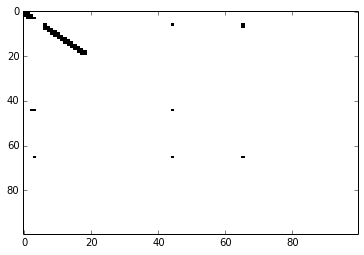

In [15]:
tm.memory.show_mem()

Current code also has capability to animate the Active and Predictive maps as the TM is learning.
The problem is that there seems to be some memory leak in Matplotlib! and it consumes quickly ~35 Mb per 20 steps.

I have in the /bin directory **anim_test.py** to test it, if you can figure out the reason don't hesitate to ping me.

Here is how you do it using DataTest object:
**
<code>
DataTest_obj.run_test(test_name, anim=True)
</code>
**
<a href='TM_test.html' target='_blank'>check testing</a> 

Bursting won't be visible because the code clears it up before the plotting happen.
That was one of the tweaks that made my code predict better (TM.predict_best_bursted()), before that I used bursted columns in the learning phase. ( In the future update, I can even preempt bursting and it may make code slightly faster, but those are details you don't have to worry for now.)

---

### <a href='TM_test.html' target='_blank'>Let's TEST it !!</a>

> Because this document became too large there is separate page on testing.. I have build simplified test framework : <a href='TM_test.html' target='_blank'>Try it out !</a>.

---

### Spatial pooler : part 2
---

> todo implementation ...

### Temporal pooler
---

> todo explanation, implementation ...


# Conclusion

There is much more to be done and especially tested. 
Those are the initial breakthroughs of the HTM theory, the most important and hardest part how to build hierarchies of HTM-regions is still ahead, but what we have is promising.

I think you now appreciate the difference between HTM and NN.
Not from the standpoint of one is better, but the difference in approach.

*One of your disappointments could be* that TM predict only single step, but this is by design.
For long term predictions I've seen Numenta videos they use separate Classifier which wraps around TM and keep tracks and probabilities of the "transitions", so that it can make multi-step predictions.

The other approach is to run multiple TM's and splice the results (I will at some point add the capability to predict nth step, it will be simple parameter when creating TM object).

The third option is using TM.forward() method (TM feeds itself, look at the code), which of course very quickly goes out of whack, but may be you can average multiple forward() prediction and it may work!! doubt it, but give it a try.
Of course the real way to do it is to build TM hierarchies, which we don't have yet.

**What are the benefits of this implementation :**

1. It is all binary, zeros and ones
2. The bulk of the algorithm are simple operations : OR, AND, count-bits, 1D <=> 2D view
3. Not much parameters to tune
4. Very friendly to optimizations, both in software (C,C++) and hardware (new type of memories, video cards). I can't stress this enough hardware acceleration will be a blast :).
5. Have found it to work satisfactory on test data-sets with small region sizes : 5x300, because connection matrix row (SDR-union) is 1500 bits
6. Very light on resources compared to full-blown implementation, so I expect it will be cheaper to build hierarchies.
7. Easy to parallelize, I think you can literally change every bit asynchronously and it will still work.

**What are the disadvantages :**

1. If I missed something obvious it may be wrong !!! doubt it, but you never know :)
My biggest concern is if I messed up the sequence of the steps when coding, which may invalidate the results, even that I replied them many time in my mind.
2. Not good to research HTM theory details, but this is an abstraction anyway.
3. Anything I have not thought about ?
4. Have not seen a performance library for doing Fast bit arrays that is tailored to the specific CPU ?!

---

The whole package is self-contained and will be easy to integrate in other projects.
I have not played with interaction between multiple TM's yet, because I'm still exploring the theory and there are many unimplemented parts of the system (more Encoders, SP, TP, multi-step/thats easy/).
I did my best for the limited time I had to test as much behaviors as I can, but there are so much variations, so I hope you will enjoy finding corner cases where current setup does not work.

Welcome any feedback, like where in the theory I got it wrong for example.
I will be grateful if somebody can compare the performance against NuPic or other approaches like NN, Arima ...etc.

---

## References

<a href='bmap2D.html' target='_blank'>BMap2D</a>

<a href='TM_test.html' target='_blank'>Testing</a>

<a href='http://ifni.co/articles/programming/recursion' target='_blank'>PatternLang()</a>

<a href='http://numenta.com/assets/pdf/whitepapers/hierarchical-temporal-memory-cortical-learning-algorithm-0.2.1-en.pdf' target='_blank'>HTM theory</a>

<a href="http://arxiv.org/pdf/1511.00083.pdf" target="_blank">HTM neuron</a>

<a href="http://arxiv.org/abs/1503.07469" target="_blank">Properties of SDR</a>

<a href='http://arxiv.org/abs/1602.05925' target='_blank'>Encoding Data for HTM Systems</a>

<a src='www.youtube.com/watch?v=qZM9JREjnp4&spfreload=5' target='_blank'>Intelligence and Machines: Creating Intelligent Machines by Modeling the Brain with Jeff Hawkins</a>

